In [1]:
# Use seaborn for pairplot
!pip install -q seaborn

# Use some functions from tensorflow_docs
!pip install -q git+https://github.com/tensorflow/docs

In [2]:

from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [3]:

dataset_path = 'C:/Users/cmedders/Data/MOPS.csv'
raw_dataset = pd.read_csv(dataset_path)

dataset = raw_dataset.copy()
dataset.tail()

,TOT,NaCl,pH,pKa
4233,0.5,35.064,8.0,6.721379
4234,0.5,40.908,8.0,6.767779
4235,0.5,46.752,8.0,6.821208
4236,0.5,52.596,8.0,6.881039
4237,0.5,58.440,8.0,6.946656


In [4]:
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

In [5]:
train_stats = train_dataset.describe()
train_stats.pop("pKa")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
TOT,3390.0,0.259948,0.145381,0.025,0.125,0.250,0.375,0.50
NaCl,3390.0,32.083388,16.808983,5.844,17.532,32.142,46.752,58.44
pH,3390.0,6.994572,0.611298,6.000,6.500,7.000,7.500,8.00


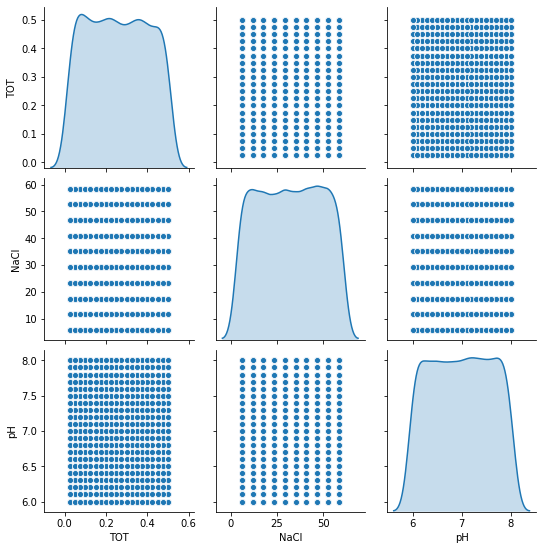

In [6]:
sns.pairplot(train_dataset[["TOT", "NaCl", "pH"]], diag_kind="kde")

In [7]:
train_labels = train_dataset.pop('pKa')
test_labels = test_dataset.pop('pKa')

In [8]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)
normed_train_data.tail()

,TOT,NaCl,pH
2636,1.651188,1.220336,0.336052
4236,1.651188,1.220336,1.644742
2380,0.791379,-0.865691,0.172465
3134,-0.068430,0.524994,0.826810
2639,-1.616085,-1.213362,0.499638


In [9]:
def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.95, beta_2=0.999, amsgrad=False)
    
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

In [10]:
model = build_model()

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                256       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 4,481
Trainable params: 4,481
Non-trainable params: 0
_________________________________________________________________


In [12]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[0.3418822 ],
       [0.0282416 ],
       [0.01099105],
       [0.02437988],
       [0.04762962],
       [0.21594533],
       [0.17977883],
       [0.18069926],
       [0.17726322],
       [0.39816558]], dtype=float32)

In [13]:
EPOCHS = 1000

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[tfdocs.modeling.EpochDots()])


Epoch: 0, loss:17.9134,  mae:3.6985,  mse:17.9134,  val_loss:2.5179,  val_mae:1.3165,  val_mse:2.5179,  
....................................................................................................
Epoch: 100, loss:0.0008,  mae:0.0219,  mse:0.0008,  val_loss:0.0009,  val_mae:0.0220,  val_mse:0.0009,  
....................................................................................................
Epoch: 200, loss:0.0004,  mae:0.0138,  mse:0.0004,  val_loss:0.0005,  val_mae:0.0187,  val_mse:0.0005,  
....................................................................................................
Epoch: 300, loss:0.0004,  mae:0.0149,  mse:0.0004,  val_loss:0.0003,  val_mae:0.0113,  val_mse:0.0003,  
....................................................................................................
Epoch: 400, loss:0.0003,  mae:0.0118,  mse:0.0003,  val_loss:0.0002,  val_mae:0.0080,  val_mse:0.0002,  
......................................................................

In [14]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
995,0.000163,0.008651,0.000163,0.000196,0.010958,0.000196,995
996,0.000145,0.008294,0.000145,0.000138,0.009250,0.000138,996
997,0.000142,0.007263,0.000142,0.000179,0.010715,0.000179,997
998,0.000162,0.008780,0.000162,0.000089,0.007096,0.000089,998
999,0.000127,0.007389,0.000127,0.000224,0.010092,0.000224,999


In [15]:
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)

Text(0, 0.5, 'MAE [pKa]')

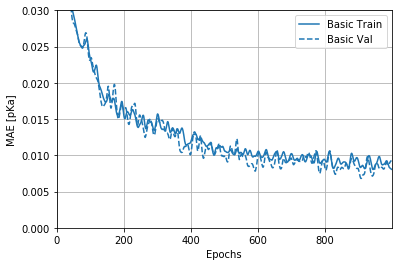

In [16]:
plotter.plot({'Basic': history}, metric = "mae")
plt.ylim([0,0.03])
plt.ylabel('MAE [pKa]')

Text(0, 0.5, 'MSE [pKa^2]')

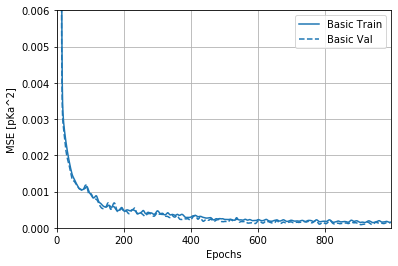

In [17]:
plotter.plot({'Basic': history}, metric = "mse")
plt.ylim([0,.0060])
plt.ylabel('MSE [pKa^2]')

In [18]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} pKa".format(mae))

848/848 - 0s - loss: 2.3520e-04 - mae: 0.0094 - mse: 2.3520e-04
Testing set Mean Abs Error:  0.01 pKa


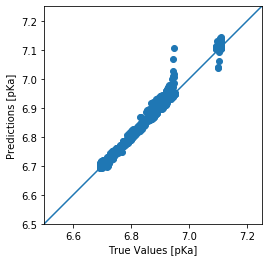

In [19]:
test_predictions = model.predict(normed_test_data).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [pKa]')
plt.ylabel('Predictions [pKa]')
lims = [6.5, 7.25]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)


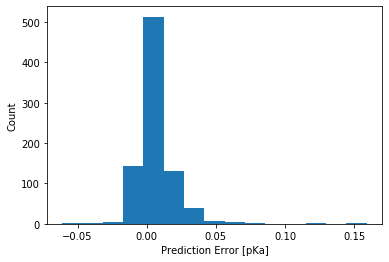

In [20]:
from tensorflow.keras.models import model_from_json
error = test_predictions - test_labels
plt.hist(error, bins = 15)
plt.xlabel("Prediction Error [pKa]")
_ = plt.ylabel("Count")
mops_json = model.to_json()
with open("mopsmodel.json", "w") as json_file:
    json_file.write(mops_json)
# serialize weights to HDF5
model.save_weights("mopsmodel.h5")

In [21]:
from ipywidgets import interact, interactive, fixed, interactive_output
from ipywidgets import FloatText, Output, HBox
import pandas as pd
json_file = open('mopsmodel.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("mopsmodel.h5")

x = FloatText(value=0.100,
    min=0.001,
    max=3.000,
    step=0.001,
    description='Total buffer molarity:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    )
y = FloatText(value=7.2,
    min=6.50,
    max=8.00,
    step=0.01,
    description='pH:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    )
z = FloatText(value=0.1,
    min=0.000,
    max=5.000,
    step=0.001,
    description='NaCl molarity:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    )
ui = HBox([x,y,z])
def f(x,y,z):    
    t = [[z,y,x]]
    dfsa= pd.DataFrame(t, columns = ['NACL', 'pH', 'TOT'])
    normdf = norm(dfsa)   
    answer = loaded_model.predict(dfsa)
    dif= y-answer
    molratio = np.power(10,dif)
    mwA = 231.25
    mHA = 209.26
    mwNaCl= 58.44
    mol_of_HA = x/(molratio + 1)
    mL_of_HA = mol_of_HA * mHA
    mol_A = x-mol_of_HA
    g_of_A = mol_A*mwA
    g_of_NaCl = mwNaCl * z
    return(print(g_of_A,"g of MOPS Na and ", mL_of_HA, "g of MOPS and ", g_of_NaCl, "g of NaCl ", answer[0], "pKa", sep=""))
out = interactive_output(f, {'x':x, 'y':y, 'z':z})
display(ui, out) 

    


Output()

In [22]:
json_file = open('mopsmodel.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("mopsmodel.h5")
from ipywidgets import interact, interactive, fixed, interactive_output
from ipywidgets import FloatText, Output, HBox
x = FloatText(value=0.100,
    min=0.001,
    max=3.000,
    step=0.001,
    description='Total buffer molarity:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    )
y = FloatText(value=7.2,
    min=6.50,
    max=8.00,
    step=0.01,
    description='pH:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    )
z = FloatText(value=0.1,
    min=0.000,
    max=5.000,
    step=0.001,
    description='NaCl molarity:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    )
ui = HBox([x,y,z])
    
t = [[z,y,x]]
df= pd.DataFrame(t, columns = ['NACL', 'pH', 'TOT'])
normdf = norm(df)
df.last()


TypeError: unsupported operand type(s) for -: 'FloatText' and 'float'